# The Datasets API: Features Overview

This tutorial provides an overview of the [Datasets data source](https://docs.dimensions.ai/dsl/datasource-datasets.html) available via the [Dimensions Analytics API](https://docs.dimensions.ai/dsl/). 

The topics covered in this notebook are:

* How to retrieve datasets metadata using the [search fields](https://docs.dimensions.ai/dsl/datasource-datasets.html) available
* How to use the [schema API](https://docs.dimensions.ai/dsl/data-sources.html#metadata-api) to obtain some statistics about the Datasets data available (a standalone version of the charts generated in this section is also available online: [dataset fields overview ](http://api-sample-data.dimensions.ai/dataviz-exports/1-introducing-datasets/dataset-fields-overview.html) | [distribution of dataset fields per years](http://api-sample-data.dimensions.ai/dataviz-exports/1-introducing-datasets/dataset-fields-by-year-count.html) ).

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *

import os, sys, time, json
from tqdm.notebook import tqdm as progress
import pandas as pd
import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.8.2)
Connected to: https://app.dimensions.ai - DSL v1.28
Method: dsl.ini file


## 1. Sample Dataset Queries

For the following queries, we will restrict our search using the keyword 'graphene'. You can of course change that, so to explore other topics too.

In [2]:
TOPIC = "graphene" #@param {type: "string"}

### Searching datasets by keyword

We can easily discover datasets mentioning the keyword `graphene` and sorting them by most recent first. 

In [3]:
df = dsl.query(f"""
search datasets 
    in full_data for "{TOPIC}" 
return datasets[basics+license] 
    sort by date_created limit 100
""").as_dataframe()

Returned Datasets: 100 (total = 832)
Time: 0.62s
WARNINGS [1]
Field 'license' is deprecated in favor of license_name. Please refer to https://docs.dimensions.ai/dsl/releasenotes.html for more details


In [4]:
df.head(3)

,id,keywords,authors,title,year,license.url,license.name,license.value,journal.id,journal.title
0,12900395,"[wound dressing, biopolymer, pyocyanin, Pseudo...","[{'name': 'Andrew C. Ward', 'orcid': ''}, {'na...","Table_1_Toward a Closed Loop, Integrated Bioco...",2020,https://creativecommons.org/licenses/by/4.0/,CC BY 4.0,1,NaN,NaN
1,12900389,"[wound dressing, biopolymer, pyocyanin, Pseudo...","[{'name': 'Andrew C. Ward', 'orcid': ''}, {'na...","Data_Sheet_1_Toward a Closed Loop, Integrated ...",2020,https://creativecommons.org/licenses/by/4.0/,CC BY 4.0,1,NaN,NaN
2,12900392,"[wound dressing, biopolymer, pyocyanin, Pseudo...","[{'name': 'Andrew C. Ward', 'orcid': ''}, {'na...","Data_Sheet_2_Toward a Closed Loop, Integrated ...",2020,https://creativecommons.org/licenses/by/4.0/,CC BY 4.0,1,NaN,NaN


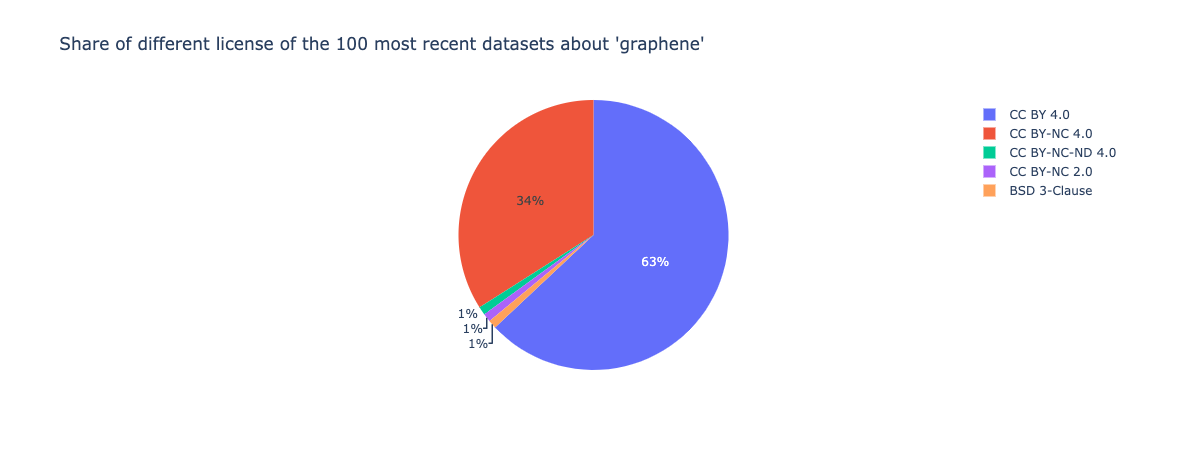

In [5]:
px.pie(df, 
       names="license.name", 
       title=f"Share of different license of the 100 most recent datasets about '{TOPIC}'")

### Returning associated grants and publication data

Whenever the information about the publication associated to a dataset is available, it can be retrieved via the `associated_publication_id` field. Similarly, links between datasets and grants are exposed via the `associated_grant_ids` field. 

In [6]:
dfPubsAndGrants = dsl.query(f"""
search datasets 
    in full_data for "{TOPIC}" 
    where associated_grant_ids is not empty
    and  associated_publication_id is not empty
return datasets[basics+associated_publication_id+associated_grant_ids+category_for] 
    sort by date_created desc limit 50
""").as_dataframe()

Returned Datasets: 50 (total = 218)
Time: 0.63s


In [7]:
dfPubsAndGrants.head(3)

,associated_grant_ids,title,authors,associated_publication_id,category_for,year,keywords,id,journal.id,journal.title
0,"[grant.2761799, grant.8158983]",Supplementary information files for Probing th...,"[{'name': 'Ya-Wei Zhou', 'orcid': ''}, {'name'...",pub.1129903102,"[{'id': '2203', 'name': '03 Chemical Sciences'...",2020,"[DFT calculations, spectroelectrochemistry, re...",12789110,jour.1039901,Applied Catalysis B Environmental
1,"[grant.7019622, grant.8145503]",Density Functional Theory Study of Single-Atom...,"[{'name': 'Chunjin Ren', 'orcid': ''}, {'name'...",pub.1127742907,"[{'id': '2210', 'name': '10 Technology'}, {'id...",2020,"[SAC, N 2 H adsorption, g-C 3 N 4 nanosheet, N...",12326369,jour.1298581,ACS Applied Nano Materials
2,"[grant.7019622, grant.8145503]",Density Functional Theory Study of Single-Atom...,"[{'name': 'Chunjin Ren', 'orcid': ''}, {'name'...",pub.1127742907,"[{'id': '2210', 'name': '10 Technology'}, {'id...",2020,"[SAC, N 2 H adsorption, g-C 3 N 4 nanosheet, N...",12326366,jour.1298581,ACS Applied Nano Materials


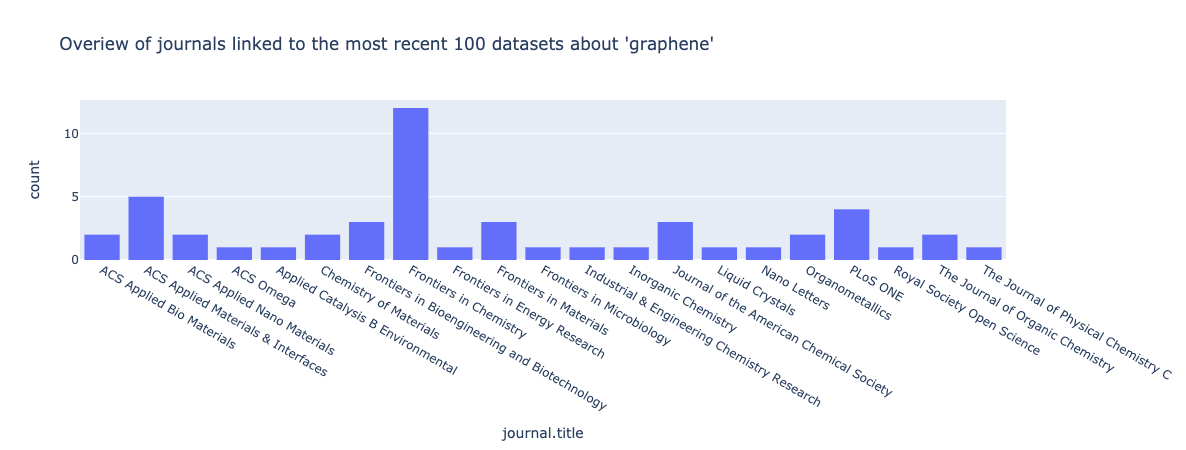

In [8]:
fig = px.histogram(dfPubsAndGrants.sort_values('journal.title'), 
                   x="journal.title", 
                   barmode="group", 
                   title=f"Overiew of journals linked to the most recent 100 datasets about '{TOPIC}'")
fig.show()

### Searching using fielded search

We can search for Datasets by using one or more [field filters](https://docs.dimensions.ai/dsl/datasource-datasets.html#datasets-fields). 

For example, we can filter by `journal`, using the most frequent journal from the dataframe created above. 

In [9]:
topjournal = dfPubsAndGrants['journal.id'].value_counts().idxmax()

dsl.query(f"""
search datasets 
    in full_data for "{TOPIC}"
    where journal.id="{topjournal}"
return datasets[basics+doi] limit 10
""").as_dataframe()

Returned Datasets: 10 (total = 35)
Time: 0.59s


,authors,title,doi,year,id,keywords,journal.id,journal.title
0,"[{'name': 'Xuan Zheng', 'orcid': ''}, {'name':...",Data_Sheet_1_Liquid Phase Exfoliated Hexagonal...,10.3389/fchem.2019.00544.s001,2019,9211262,"[heterostructure, h-BN, graphene, asymmetric s...",jour.1049812,Frontiers in Chemistry
1,"[{'name': 'Kaihe Lv', 'orcid': ''}, {'name': '...",Data_Sheet_1_Study of Janus Amphiphilic Graphe...,10.3389/fchem.2020.00201.s001,2020,12128463,"[graphene oxide, Janus amphiphilic nano-sheets...",jour.1049812,Frontiers in Chemistry
2,"[{'name': 'Hui Li', 'orcid': ''}, {'name': 'Ba...",Data_Sheet_1_Heterostructured SnO2-SnS2@C Embe...,10.3389/fchem.2019.00339.s001,2019,8121764,"[SnO2-SnS2, heterostructure, nitrogen-doped gr...",jour.1049812,Frontiers in Chemistry
3,"[{'name': 'Qunpeng Duan', 'orcid': ''}, {'name...",Data_Sheet_1_Facile One-Step Electrodeposition...,10.3389/fchem.2020.00430.s001,2020,12423572,"[electrodeposition, pillar[6]arene, host-guest...",jour.1049812,Frontiers in Chemistry
4,"[{'name': 'Jingjing Chen', 'orcid': ''}, {'nam...",Data_Sheet_1_Vitrimer Chemistry Assisted Fabri...,10.3389/fchem.2019.00632.s001,2019,9822770,"[graphene nanoplate, vitrimer, composite, alig...",jour.1049812,Frontiers in Chemistry
5,"[{'name': 'Hongwei Mi', 'orcid': ''}, {'name':...",Table_1_Carbothermal Synthesis of Nitrogen-Dop...,10.3389/fchem.2018.00501.s001,2018,7234382,"[liquid-polyacrylonitrile (LPAN), carbothermal...",jour.1049812,Frontiers in Chemistry
6,"[{'name': 'Wei Zhang', 'orcid': ''}, {'name': ...",Table_1_Pyrite-Type CoS2 Nanoparticles Support...,10.3389/fchem.2018.00569.s001,2018,7368707,"[water splitting, cobalt sulfide, nanoparticle...",jour.1049812,Frontiers in Chemistry
7,"[{'name': 'Dan-Dan Zhang', 'orcid': ''}, {'nam...",Data_Sheet_1_Perovskite-WS2 Nanosheet Composit...,10.3389/fchem.2019.00257.s001,2019,8094617,"[reduced graphene oxide, perovskite, WS2, bulk...",jour.1049812,Frontiers in Chemistry
8,"[{'name': 'Xiaoyu Song', 'orcid': ''}, {'name'...",Table_1_Deep Eutectic Solvent Micro-Functional...,10.3389/fchem.2019.00594.s001,2019,9725681,"[deep eutectic solvent, graphene, dispersive m...",jour.1049812,Frontiers in Chemistry
9,"[{'name': 'Emilie Bordes', 'orcid': ''}, {'nam...",Data_Sheet_1_Dispersion and Stabilization of E...,10.3389/fchem.2019.00223.s001,2019,7998800,"[exfoliation, graphene, graphite, ionic liquid...",jour.1049812,Frontiers in Chemistry


### Extracting related funding via grants 

In [10]:
# get unique list of associated grant IDs
grantids = list()
for g in dfPubsAndGrants['associated_grant_ids'].to_list():
  grantids += g
grantids = list(set(grantids))

# get more grants data from IDs
dfgrants = dsl.query(f"""search grants 
                      where id in {json.dumps(grantids)} 
                   return grants[id+funding_org_name+funder_countries+funding_eur] limit 1000 """).as_dataframe()


Returned Grants: 66 (total = 66)
Time: 0.56s


In [11]:
dfgrants.head(5)

,funding_org_name,funding_eur,funder_countries,id
0,European Research Council,2000000.0,"[{'id': 'BE', 'name': 'Belgium'}]",grant.8104355
1,Office of the Director,224831.0,"[{'id': 'US', 'name': 'United States'}]",grant.7569828
2,Japan Society for the Promotion of Science,139549.0,"[{'id': 'JP', 'name': 'Japan'}]",grant.7521593
3,National Natural Science Foundation of China,82360.0,"[{'id': 'CN', 'name': 'China'}]",grant.8133465
4,National Natural Science Foundation of China,56617.0,"[{'id': 'CN', 'name': 'China'}]",grant.8132071


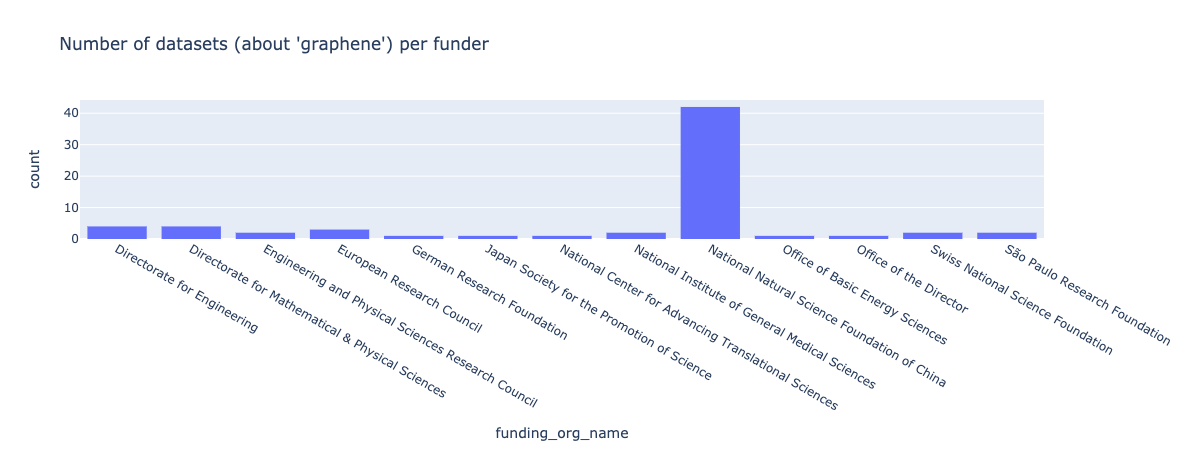

In [12]:
fig = px.histogram(dfgrants.sort_values('funding_org_name'), 
                   x="funding_org_name", 
                   barmode="group", 
                   title=f"Number of datasets (about '{TOPIC}') per funder")
fig.show()

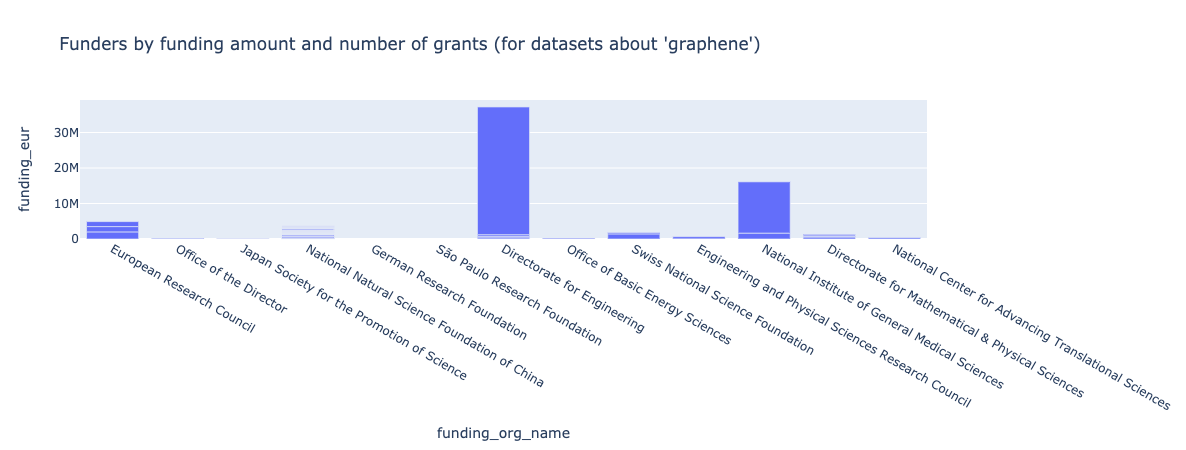

In [13]:
fig = px.bar(dfgrants, 
             x="funding_org_name", y="funding_eur", 
             barmode="group", 
             title=f"Funders by funding amount and number of grants (for datasets about '{TOPIC}')")
fig.show()

In [14]:
dfgrants.sort_values('funding_eur',ascending=False).head(5)

,funding_org_name,funding_eur,funder_countries,id
61,Directorate for Engineering,35986896.0,"[{'id': 'US', 'name': 'United States'}]",grant.3106944
65,National Institute of General Medical Sciences,14446408.0,"[{'id': 'US', 'name': 'United States'}]",grant.2439760
0,European Research Council,2000000.0,"[{'id': 'BE', 'name': 'Belgium'}]",grant.8104355
41,National Institute of General Medical Sciences,1660554.0,"[{'id': 'US', 'name': 'United States'}]",grant.6377824
25,European Research Council,1499925.0,"[{'id': 'BE', 'name': 'Belgium'}]",grant.6447261


### Aggregating results using facets

Datasets results can be grouped using facets. E.g. we can see what are the top `funders`, `research organizations` or  `researchers` related to our datasets (note: the column 'count' represents the number of dataset records in each of the groups).

#### Top funders

In [15]:
df = dsl.query(f"""
search datasets 
    in full_data for "{TOPIC}" 
return funders limit 100
""").as_dataframe()

Returned Funders: 100
Time: 0.50s


In [16]:
df.head(3)

,id,count,linkout,types,longitude,latitude,acronym,name,country_name,city_name,state_name
0,grid.419696.5,103,[http://www.nsfc.gov.cn/publish/portal1/],[Government],116.33983,40.005177,NSFC,National Natural Science Foundation of China,China,Beijing,NaN
1,grid.270680.b,28,[http://ec.europa.eu/index_en.htm],[Government],4.36367,50.851650,EC,European Commission,Belgium,Brussels,NaN
2,grid.457875.c,26,[http://www.nsf.gov/dir/index.jsp?org=MPS],[Government],-77.11099,38.880566,NSF MPS,Directorate for Mathematical & Physical Sciences,United States,Arlington,Virginia


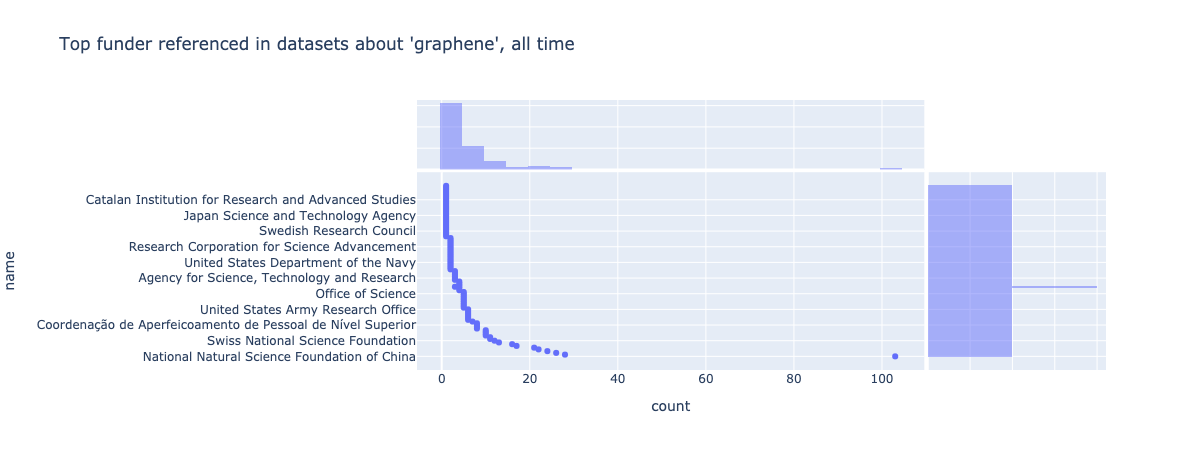

In [17]:
px.scatter(df, 
           x="count", y="name",
           marginal_x="histogram", marginal_y="histogram",
           title=f"Top funder referenced in datasets about '{TOPIC}', all time")

#### Top research organizations

Note: research organizations are linked to datasets via the datasets' associated publication. 

In [18]:
df = dsl.query(f"""
search datasets 
    in full_data for "{TOPIC}" 
return research_orgs limit 10
""").as_dataframe()

Returned Research_orgs: 10
Time: 0.46s


In [19]:
df.head()

,id,count,longitude,city_name,types,country_name,name,latitude,linkout,acronym,state_name
0,grid.10347.31,24,101.656390,Kuala Lumpur,[Education],Malaysia,University of Malaya,3.120833,[https://www.um.edu.my/],UM,NaN
1,grid.418028.7,16,13.283713,Berlin,[Facility],Germany,Fritz Haber Institute of the Max Planck Society,52.448765,[http://www.fhi-berlin.mpg.de/],FHI,NaN
2,grid.34555.32,15,30.511314,Kyiv,[Education],Ukraine,Taras Shevchenko National University of Kyiv,50.441902,[http://www.univ.kiev.ua/en/],KNU,NaN
3,grid.263333.4,12,127.073890,Seoul,[Education],South Korea,Sejong University,37.550835,[http://www.sejong.ac.kr/],NaN,NaN
4,grid.264756.4,12,-96.344055,College Station,[Education],United States,Texas A&M University,30.610369,[https://www.tamu.edu/],TAMU,Texas


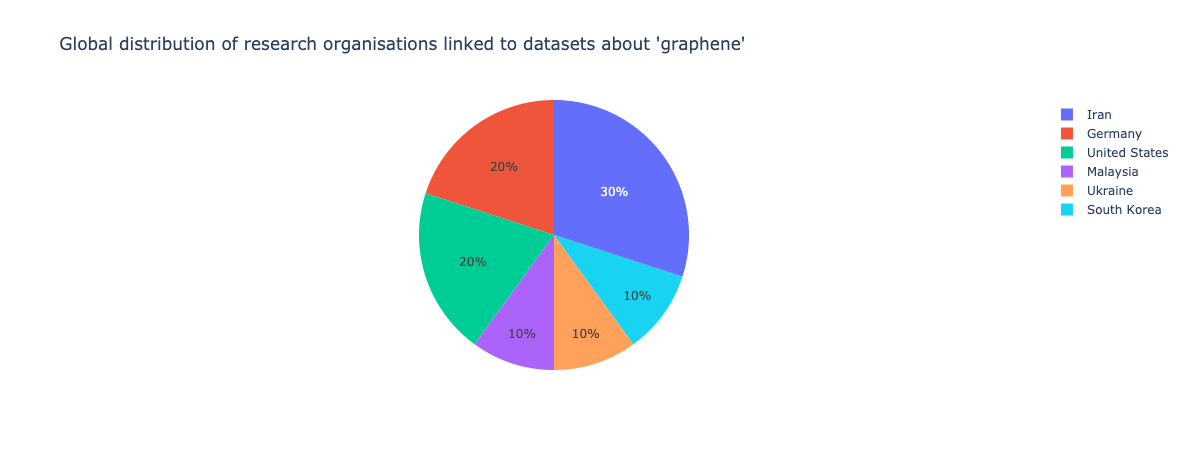

In [20]:
px.pie(df, 
       names="country_name",
       title=f"Global distribution of research organisations linked to datasets about '{TOPIC}'")

#### Top contributors

Note: researchers are linked to datasets via the datasets' associated publication. 

In [21]:
dsl.query(f"""
search datasets 
    in full_data for "{TOPIC}" 
return researchers limit 10
""").as_dataframe()

Returned Researchers: 10
Time: 0.58s


,id,count,last_name,research_orgs,first_name,orcid_id
0,ur.01046566370.94,15,Frank,"[grid.418028.7, grid.6734.6]",Benjamin,NaN
1,ur.01333027111.96,15,Schlögl,"[grid.5018.c, grid.5398.7, grid.5335.0, grid.4...",Robert,NaN
2,ur.01347070166.03,15,Khavryuchenko,"[grid.440789.6, grid.418028.7, grid.34555.32, ...",Oleksiy V,NaN
3,ur.013720757463.40,15,Hermann,"[grid.424048.e, grid.481551.c, grid.7450.6, gr...",Klaus E,[0000-0002-3861-3916]
4,ur.0714064131.80,15,Trunschke,"[grid.418028.7, grid.4372.2, grid.440957.b, gr...",Annette,NaN
5,ur.010553550461.38,12,Rezania,"[grid.410877.d, grid.31501.36, grid.263333.4]",Shahabaldin,[0000-0001-8943-3045]
6,ur.01230367167.34,12,Talebi,"[grid.411705.6, grid.444858.1]",Seyedeh Solmaz,NaN
7,ur.012742050435.43,12,Nezhad,[grid.411583.a],Nahid Tavakkoli,NaN
8,ur.013616637374.40,12,Ghadiri,"[grid.411705.6, grid.444858.1]",Seid Kamal,NaN
9,ur.015117735007.22,12,Shams,"[grid.411924.b, grid.411583.a, grid.411705.6]",Mahmoud,[0000-0002-2222-9792]


## 2. A closer look at Datasets statistics

The Dimensions Search Language [exposes programmatically metadata](https://docs.dimensions.ai/dsl/data-sources.html#metadata-api), such as supported sources and entities, along with their fields, facets, fieldsets, metrics and search fields. 


In [22]:
%dsldocs datasets

,sources,field,type,description,is_filter,is_entity,is_facet
0,datasets,associated_grant_ids,string,The Dimensions IDs of the grants linked to the...,True,False,False
1,datasets,associated_publication,publication_links,Publication linked to the dataset (single value).,True,True,True
2,datasets,associated_publication_id,string,The Dimensions ID of the publication linked to...,True,False,False
3,datasets,authors,json,Ordered list of the dataset authors. ORCIDs ar...,True,False,False
4,datasets,category_bra,categories,`Broad Research Areas <https://app.dimensions....,True,True,True
5,datasets,category_for,categories,`ANZSRC Fields of Research classification <htt...,True,True,True
6,datasets,category_hra,categories,`Health Research Areas <https://app.dimensions...,True,True,True
7,datasets,category_hrcs_hc,categories,`HRCS - Health Categories <https://app.dimensi...,True,True,True
8,datasets,category_hrcs_rac,categories,`HRCS – Research Activity Codes <https://app.d...,True,True,True
9,datasets,category_icrp_cso,categories,`ICRP Common Scientific Outline <https://app.d...,True,True,True


The fields list shown above can be extracted via the following DSL query:

In [23]:
data = dsl.query("""describe source datasets""")
fields = sorted([x for x in data.fields.keys()])

### Counting records per each field

By using the fields list obtained above, it is possible to draw up some general statistics re. the Datasets content type in Dimensions.

In order to do this, we  use the operator `is not empty` to generate automatically queries like this `search datasets where {field_name} is not empty return datasets limit 1` and then use the `total_count` field in the JSON we get back for our statistics. 

In [24]:
q_template = """search datasets where {} is not empty return datasets[id] limit 1"""

# seed results with total number of orgs
total = dsl.query("""search datasets return datasets[id] limit 1""", verbose=False).count_total
stats = [
    {'filter_by': 'no filter (=all records)', 'results' : total}
]

for f in progress(fields):
    q = q_template.format(f)
    res = dsl.query(q, verbose=False)
    time.sleep(0.5)
    stats.append({'filter_by': f, 'results' : res.count_total})


df = pd.DataFrame().from_dict(stats)
df.sort_values("results", inplace=True, ascending=False)
df

,filter_by,results
0,no filter (=all records),1562963
14,date,1562963
38,title,1562963
25,id,1562963
22,figshare_url,1562963
17,date_inserted,1562963
15,date_created,1562963
20,dimensions_url,1562963
39,year,1562963
4,authors,1562963


### Creating a bar chart

> NOTE: a standalone version of this chart is also [available online](http://api-sample-data.dimensions.ai/dataviz-exports/1-introducing-datasets/dataset-fields-overview.html)

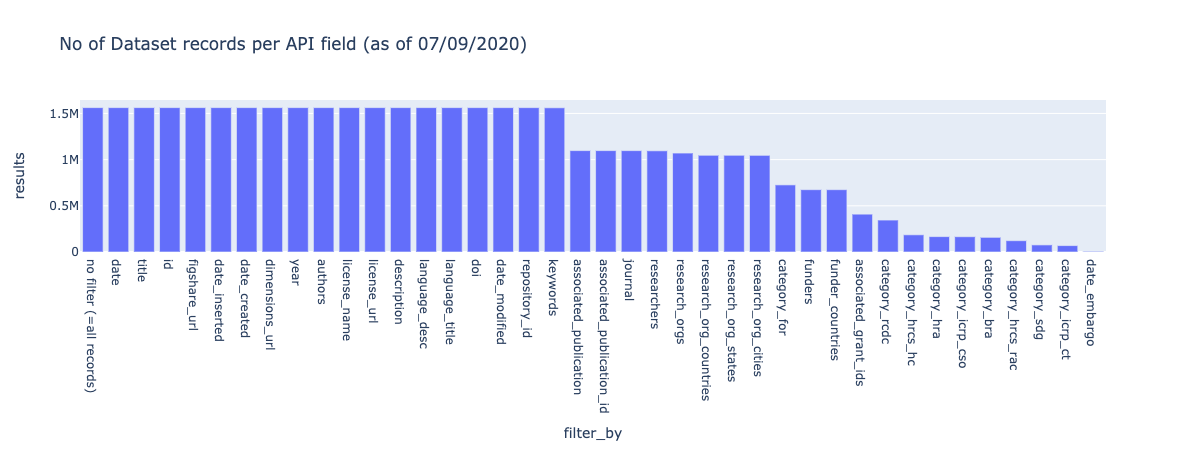

In [25]:
from datetime import date
today = date.today().strftime("%d/%m/%Y")

fig = px.bar(df, 
             x=df['filter_by'], 
             y=df['results'],
             title=f"No of Dataset records per API field (as of {today})")

plot(fig, filename = 'dataset-fields-overview.html', auto_open=False)
fig.show()

### Counting the yearly distribution of field/records data 



In [26]:
#
# get how many dataset records have values for each field, for each year
#

q_template = """search datasets where {} is not empty return year limit 150"""

# seed with all records data (no filter)
seed = dsl.query("""search datasets return year limit 150""", verbose=False).as_dataframe()
seed['segment'] = "all records"

for f in progress(fields):
    q = q_template.format(f)
    res = dsl.query(q, verbose=False).as_dataframe()
    res['segment'] = f
    seed = seed.append(res, ignore_index=True )
    time.sleep(0.5)

seed = seed.rename(columns={'id' : 'year'})
seed = seed.astype({'year': 'int32'})

#
# fill in (normalize) missing years in order to build a line chart
#

yrange = [seed['year'].min(), seed['year'].max()]
# TIP yrange[1]+1 to make sure max value is included
all_years = [x for x in range(yrange[0], yrange[1]+1)]  

def add_missing_years(field_name):
    global seed
    known_years = list(seed[seed["segment"] == field_name]['year'])
    l = [] 
    for x in all_years:
        if x not in known_years:
            l.append({'segment' : field_name , 'year' : x, 'count': 0 })
    seed = seed.append(l, ignore_index=True )
    
all_field_names = seed['segment'].value_counts().index.tolist()
for field in all_field_names:
    add_missing_years(field)
    

### Creating a line chart 

> NOTE: a standalone version of this chart is also [available online](http://api-sample-data.dimensions.ai/dataviz-exports/1-introducing-datasets/dataset-fields-by-year-count.html)

A few things to remember: 

* There are a lot of overlapping lines, as many fields appear frequently; hence it's useful to click on the right panel to hide/reveal specific segments.  
* We set a start year to avoid having a long tail of (very few) datasets published a long time ago. 

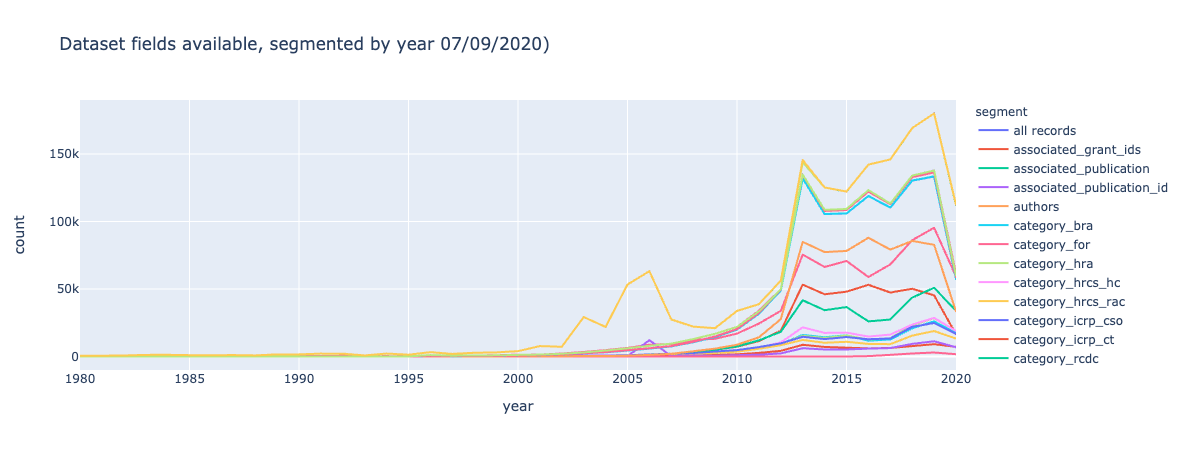

In [27]:
start_year = 1980

# need to sort otherwise the chart is messed up!
temp = seed.query(f"year >= {start_year}").sort_values(["segment", "year"]) 
# 
fig = px.line(temp, 
              x="year", 
              y="count", 
              color="segment",
               title=f"Dataset fields available, segmented by year {today})")

plot(fig, filename = 'dataset-fields-by-year-count.html', auto_open=False)
fig.show()

## Where to find out more



Please have a look at the [official documentation](https://docs.dimensions.ai/dsl/datasource-datasets.html) for more information on Datasets.